#### Import all the required packages

In [23]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [24]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [25]:
crime_keywords = ["crime","mystery","conspiracy","mysteries","mysterious","murder","kidnap",\
                   "thriller","cop","cops","detective","dead","homicide",\
                   "killer","psychopath","serial-killer","true-crime",\
                   "terror","conspiracy-theory","ghost","supernatural","aliens",\
                   "alien","suspense"]

genres_topics = crime_keywords

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [26]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [27]:
crime_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("crime" in val)\
                                                                or ("mystery" in val)\
                                                                or ("conspiracy" in val)\
                                                                or ("mysteries" in val)\
                                                                or ("mysterious" in val)\
                                                                or ("meditation" in val)\
                                                                or ("murder" in val)\
                                                                or ("kidnap" in val)\
                                                                or ("thriller" in val)\
                                                                or ("cop" in val)\
                                                                or ("cops" in val)\
                                                                or ("detective" in val)\
                                                                or ("dead" in val)\
                                                                or ("homicide" in val)\
                                                                or ("killer" in val)\
                                                                or ("psychopath" in val)\
                                                                or ("serial-killer" in val)\
                                                                or ("true-crime" in val)\
                                                                or ("terror" in val)\
                                                                or ("conspiracy-theory" in val)\
                                                                or ("ghost" in val)\
                                                                or ("supernatural" in val)\
                                                                or ("alien" in val)\
                                                                or ("aliens" in val)\
                                                                or ("suspense" in val)]

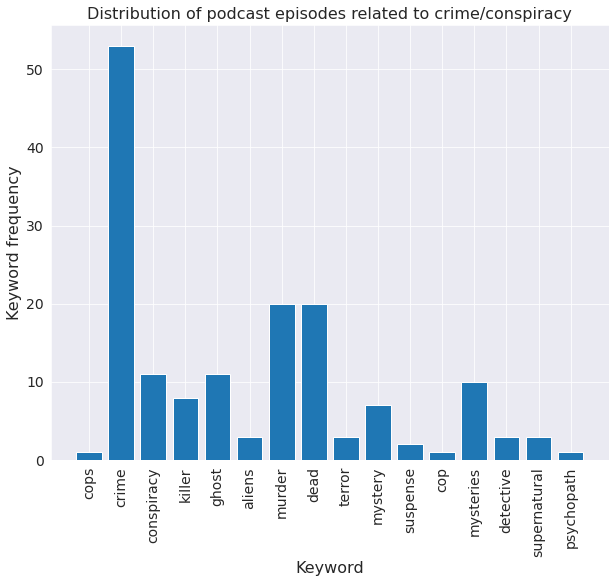

In [28]:
d = {}
for val in podcasts_genres_topics.values():
    for word in crime_keywords:
        if word in val:
            if word in d:
                d[word] += 1
            else:
                d[word] = 1
                
plt.figure(figsize=(10,8))
plt.bar(d.keys(),d.values())
plt.title('Distribution of podcast episodes related to crime/conspiracy',fontsize=16)
plt.xlabel('Keyword',fontsize=16)
plt.ylabel('Keyword frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [67]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
crime_cs = []
with open('/home1/sgmark/capstone-project/results/coherence_scores_crime_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        crime_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[5] for x in crime_cs])]

In [68]:
best_hp_setting

(5, (8, 0.8))

#### The individual transcript location

In [ ]:
# def file_location(show,episode):
#     search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
#                                + "/" + show[0] \
#                                + "/" + show[1] \
#                                + "/" + "show_" + show \
#                                + "/"
#     return search_string

#### load the transcripts

In [29]:
transcripts = {}
for podcast,genre in crime_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('/home1/sgmark/podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [70]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

#### tokenize/convert text into words

In [71]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [72]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))
    
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [73]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [74]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [75]:
corpus = [dictionary.doc2bow(text) for text in texts]

####  Hyperparameter tuning

In [ ]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_crime_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

#### Final model

In [76]:
%%time
import logging
logging.basicConfig(filename='crime_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 55.8 s, sys: 23.1 ms, total: 55.8 s
Wall time: 55.9 s


In [77]:
top_topics = lda_model.top_topics(corpus,texts=texts,coherence='c_npmi') #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)
print(f'topic coherence scores: {[t[1] for t in top_topics]}')

Average topic coherence: -0.0085.
topic coherence scores: [0.03143845464294091, 0.020521291217581162, 0.0012365440676438762, -0.03536997974579699, -0.06034565675148491]


### Visualizing data

In [82]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_json(vis,'crime_umass.json')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.170378 -0.019327       1        1  31.153907
1      0.097886  0.193005       2        1  20.134165
3     -0.186595 -0.107641       3        1  19.598262
4     -0.166581  0.166147       4        1  18.411451
2      0.084912 -0.232184       5        1  10.702216, topic_info=            Term         Freq        Total Category  logprob  loglift
1647      murder  9329.000000  9329.000000  Default  20.0000  20.0000
186       police  6011.000000  6011.000000  Default  19.0000  19.0000
57         crime  5857.000000  5857.000000  Default  18.0000  18.0000
2165  conspiracy  2569.000000  2569.000000  Default  17.0000  17.0000
134         kind  4456.000000  4456.000000  Default  16.0000  16.0000
...          ...          ...          ...      ...      ...      ...
1647      murder   721.581198  9329.998921   Topic5  -5.2257  -0.3248
63         death   592.271499  4161.488442   Topic5  -5.4232   0.2851
574        black   461.739762  1571.656260   Topic5  -5.6721   1.0098
57         crime   533.556444  5857.401468   Topic5  -5.5276  -0.1612
125        house   503.696483  3952.641072   Topic5  -5.5852   0.1746

[267 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1873       3  0.996190  aircraft
4283       2  0.992747     album
4827       1  0.007044    alfred
4827       5  0.989685    alfred
10864      2  0.994221    alicia
...      ...       ...       ...
5023       3  0.085213      york
5023       4  0.082464      york
5023       5  0.437060      york
2869       2  0.980873   youtube
2869       4  0.019916   youtube

[542 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

In [ ]:
# from pprint import pprint
# pprint(top_topics)

In [79]:
import pickle

pickle.dump(lda_model,open('../model/crime_episodes_lda_model_umass.pkl','wb'))
pickle.dump(dictionary,open('../model/crime_episodes_dictionary_umass.pkl','wb'))
pickle.dump(corpus,open('../model/crime_episodes_corpus_umass.pkl','wb'))
# pickle.dump(texts,open('../model/crime_episodes_texts.pkl','wb'))

In [30]:
import pickle

file = open('../model/crime_episodes_lda_model_umass.pkl','rb')
lda_model = pickle.load(file)
file.close()

file = open('../model/crime_episodes_corpus_umass.pkl','rb')
corpus = pickle.load(file)
file.close()

file = open('../model/crime_episodes_dictionary_umass.pkl','rb')
dictionary = pickle.load(file)
file.close()

file = open('../model/crime_episodes_texts.pkl','rb')
texts = pickle.load(file)
file.close()

In [32]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    rss_link_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        rss_link_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].rss_link.iloc[0])
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode'),
                           pd.Series(rss_link_list, name='rss_link')], axis=1)

    return result_df

In [33]:
main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('../model/crime_topics_main_df_umass.pkl')

In [34]:
main_topic_df.to_csv('../model/crime_topics_main_df_umass.csv')

In [32]:
topics_terms = {k:lda_model.show_topic(k,topn=30) for k in range(lda_model.num_topics)}

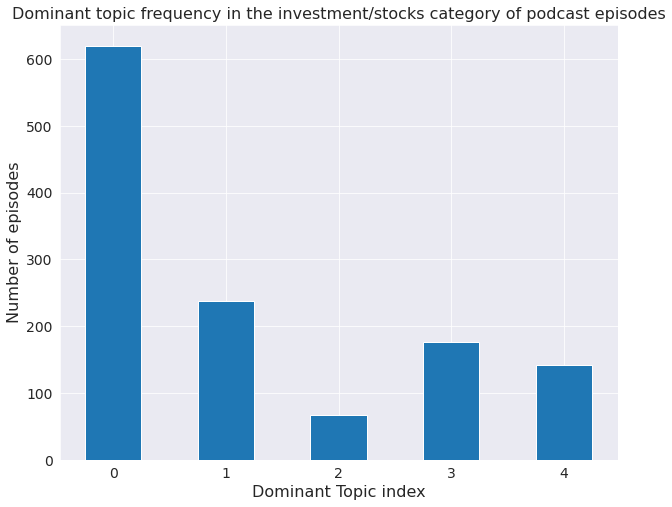

In [46]:
plt.figure(figsize=(10,8))
topics_groups = main_topic_df.groupby('Dominant_topic')
plt.bar(range(lda_model.num_topics),topics_groups.count()['Podcast_name'],width=0.5)
plt.title('Dominant topic frequency in the investment/stocks category of podcast episodes',fontsize=16)
plt.xlabel('Dominant Topic index',fontsize=16)
plt.ylabel('Number of episodes',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [47]:
representatives = pd.DataFrame()

for k in topics_groups.groups.keys():
    representatives = pd.concat([representatives, 
                                 topics_groups.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
    
representatives.to_csv('../model/main_df_csv/crime_representatives_umass.csv')
    
# for k,words in enumerate(representatives.Keywords):
#     print(f'topic {k}: {words}')

In [ ]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [36]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in topics_groups.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [37]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=7), Output()), _dom_classes=('widget-interac…

In [38]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])
#print('Indices of top words: \n{}\n'.format(lda_top_words_index))

In [39]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [45]:
lda_model.get_topic_terms(0)

[(1577, 0.036904003),
 (181, 0.023580289),
 (31, 0.016228786),
 (400, 0.01500449),
 (55, 0.012971266),
 (299, 0.0117351515),
 (117, 0.009936098),
 (1463, 0.00955281),
 (1647, 0.006989621),
 (1760, 0.0066313143)]

In [40]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

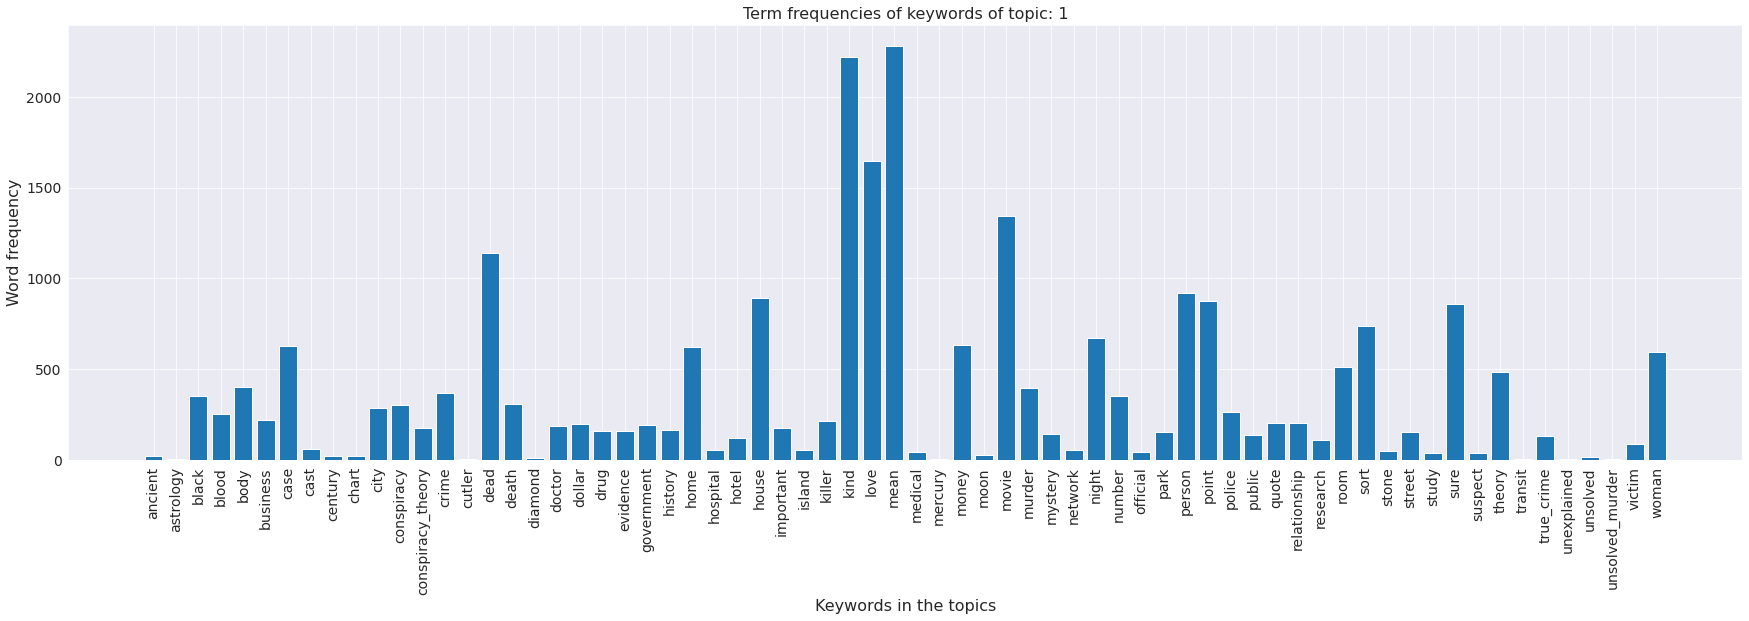

In [41]:
k=1
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(k)
plt.figure(figsize=(30,8))
plt.bar(list(clusterwise_words_dist.sum()[:-1].transpose().index),\
        list(clusterwise_words_dist.sum()[:-1].transpose()))
plt.title(f'Term frequencies of keywords of topic: {k}',fontsize=16)
plt.xlabel('Keywords in the topics',fontsize=16)
plt.ylabel('Word frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [21]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(lda_model.top_topics(corpus,texts,dictionary))}

In [22]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.figure(figsize=(10,8))
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=lda_model.num_topics-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=4), Output()), _dom_classes=('widget-interac…